# Solar Irradiance Prediction

Site data generated for the location Plataforma Solar de Almeria, Spain
Coordinates: 37.094416°N, 2.359850°W
Elevation: 497.0 m a.s.l.

Time period: 1994-2016 (23 years of data)

**GHI** : Global horizontal irradiation [Wh/m²]

**DNI** : Direct normal irradiation [Wh/m²]

**DIF** : Diffuse horizontal irradiation [Wh/m²]

**GTI** : Global tilted irradiation [Wh/m²] (fixed inclination: 33 deg. azimuth: 180 deg.)

**flagR** : Cloud identification quality   

```
flag: 0: sun below horizon,  
      1: model value,  
      2: interpolated 1hour,  
      5: long term monthly median or persistence,  
      6: synthetic data,  
      11:NWP forecast
```

**SE** : Sun altitude (elevation) angle [deg.]

**SA** : Sun azimuth angle [deg.]

**TEMP** : Air temperature at 2 m [deg. C]

**AP** : Atmospheric pressure [hPa]

**RH** : Relative humidity [%]

**WS** : Wind speed at 10 m [m/s]

**WD** : Wind direction [deg.]

**PWAT** : Precipitable water [kg/m²]

### Multivariate Forecasting using RNN-LSTM.

Import the libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


%matplotlib inline
sns.set_style("darkgrid")

Using TensorFlow backend.


In [0]:
df = pd.read_csv("Solargis-TS-hourly-SOLARGIS-PlataformaSolardeAlmeria-Spain-v2-19940101-20161231.csv", sep=";", parse_dates=['Date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201624 entries, 0 to 201623
Data columns (total 15 columns):
Date     201624 non-null datetime64[ns]
Time     201624 non-null object
GHI      201624 non-null int64
DNI      201624 non-null int64
DIF      201624 non-null int64
GTI      201624 non-null int64
flagR    201624 non-null int64
SE       201624 non-null float64
SA       201624 non-null float64
TEMP     201624 non-null float64
AP       201624 non-null float64
RH       201624 non-null float64
WS       201624 non-null float64
WD       201624 non-null int64
PWAT     201624 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(6), object(1)
memory usage: 23.1+ MB


In [67]:
df.describe()

,Avg_rad,SE,SA,TEMP,AP,RH,WS,WD,PWAT
count,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000,8401.000000
mean,194.378121,0.336756,-1.702669,16.078459,959.991925,57.456262,3.176526,183.278285,15.939218
std,71.407863,12.362233,2.214741,6.771543,5.598426,15.375058,1.309607,85.139355,5.942468
min,8.697917,-17.444583,-5.359167,-3.675000,932.537500,9.445833,0.712500,17.041667,2.045833
25%,148.947917,-12.019167,-3.239167,10.470833,956.683333,46.483333,2.266667,99.083333,11.391667
50%,200.812500,0.622083,-1.858333,15.520833,960.012500,57.695833,2.883333,197.083333,15.583333
75%,256.010417,12.684167,-0.473750,22.045833,963.291667,68.733333,3.733333,259.125000,20.104167
max,315.218750,17.557083,2.475833,34.412500,982.920833,94.570833,10.620833,345.375000,37.808333


In [5]:
df.head()

,Date,Time,GHI,DNI,DIF,GTI,flagR,SE,SA,TEMP,AP,RH,WS,WD,PWAT
0,1994-01-01,00:30,0,0,0,0,0,-74.66,-162.92,10.8,969.6,60.3,3.3,322,12.6
1,1994-01-01,01:30,0,0,0,0,0,-67.59,-124.93,10.5,968.1,62.5,5.7,320,11.0
2,1994-01-01,02:30,0,0,0,0,0,-56.82,-105.59,10.0,968.2,63.5,6.1,323,9.5
3,1994-01-01,03:30,0,0,0,0,0,-45.07,-93.83,9.5,968.4,64.3,6.4,327,8.4
4,1994-01-01,04:30,0,0,0,0,0,-33.14,-84.78,9.0,968.6,64.9,6.2,331,7.5


Drop the `Time` column because we'll be making predictions based on average radiation per day.  
Drop the `flagR` column.

In [0]:
df.drop(["Time"], axis=1, inplace=True)
df.drop(["flagR"], axis=1, inplace=True)

Getting the average/day of all the attributes.





In [0]:
df['Avg_rad'] = (df.GHI + df.DNI + df.DIF + df.GTI)/4

In [0]:
df = df.groupby("Date").mean()[["Avg_rad", "SE", "SA", "TEMP", "AP", "RH", "WS", "WD", "PWAT"]]

In [10]:
df.head()

,Avg_rad,SE,SA,TEMP,AP,RH,WS,WD,PWAT
Date,,,,,,,,,
1994-01-01,154.916667,-17.118333,-2.526667,11.808333,968.900000,44.304167,4.195833,301.375000,6.641667
1994-01-02,183.802083,-12.861250,-5.042500,7.437500,965.879167,66.295833,1.420833,209.666667,9.058333
1994-01-03,89.604167,-5.719583,-4.917500,9.283333,956.462500,70.662500,3.275000,123.625000,13.420833
1994-01-04,213.489583,3.547917,-2.772083,17.562500,961.125000,36.558333,4.900000,310.000000,13.445833
1994-01-05,296.333333,11.472500,-0.962917,14.608333,965.758333,50.462500,2.154167,87.666667,8.287500


**We'll be predicting the Average Radiation based on all the other parameters.  
train : 8232 rows  
test: 169 rows**

**train :  1994-01-06 to 2016-07-15**  
**test:  2016-07-16 to 2016-12-31**

In [0]:
dataset_train, dataset_test = train_test_split(df, test_size=0.02, shuffle=False)

In [0]:
dataset_train.reset_index(inplace=True)
dataset_test.reset_index(inplace=True)

**Test data.**

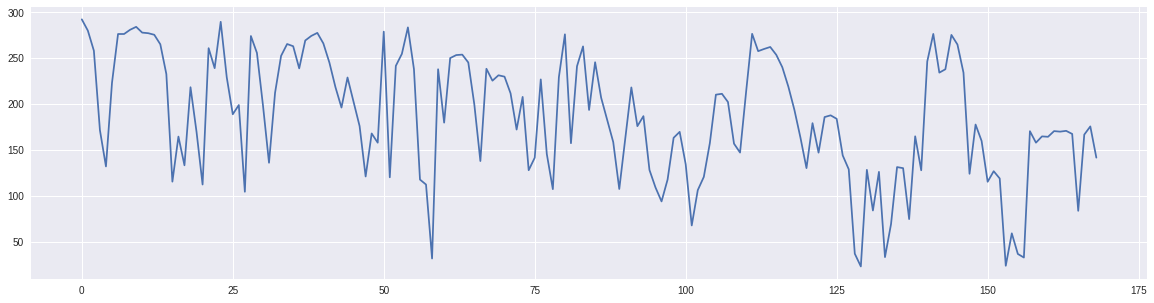

In [13]:
plt.figure(figsize=(20, 5))
dataset_test["Avg_rad"].plot()

**Train data.**

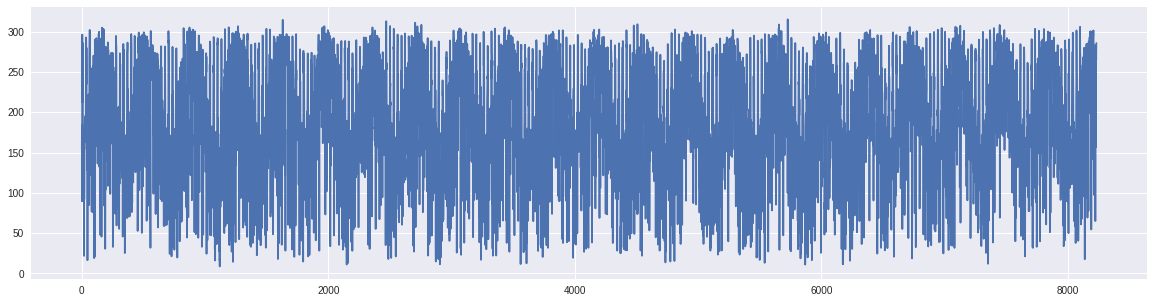

In [14]:
plt.figure(figsize=(20, 5))
dataset_train["Avg_rad"].plot()

**cols is the numer of predictors **

In [0]:
cols = 10

In [0]:
training_set = dataset_train.iloc[:, 1:cols].values

In [18]:
training_set.shape

(8232, 9)

**Normalize the training data.**

In [0]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
X_train = []
y_train = []

In [21]:
dataset_train.head()

,Date,Avg_rad,SE,SA,TEMP,AP,RH,WS,WD,PWAT
0,1994-01-01,154.916667,-17.118333,-2.526667,11.808333,968.900000,44.304167,4.195833,301.375000,6.641667
1,1994-01-02,183.802083,-12.861250,-5.042500,7.437500,965.879167,66.295833,1.420833,209.666667,9.058333
2,1994-01-03,89.604167,-5.719583,-4.917500,9.283333,956.462500,70.662500,3.275000,123.625000,13.420833
3,1994-01-04,213.489583,3.547917,-2.772083,17.562500,961.125000,36.558333,4.900000,310.000000,13.445833
4,1994-01-05,296.333333,11.472500,-0.962917,14.608333,965.758333,50.462500,2.154167,87.666667,8.287500


**Here, we are looking the previous 60 day data to predict on the 61st day. That is, we train our model on previous 60 days data to predict 1 day in the future. We are using the `Avg_rad, SE, SA, TEMP, AP, RH, WS, WD, PWAT` of previous 60 days to predict the `Avg_rad` of the next 1 day.**

In [0]:
timesteps = 60

In [0]:
for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timesteps:i, :])
    y_train.append(training_set_scaled[i, 0])

    
X_train, y_train = np.array(X_train), np.array(y_train)   

In [24]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X_train:  (8172, 60, 9)
y_train:  (8172,)


**Train using GridSearchCV**

In [0]:
# def build_regressor(optim):
#     regressor = Sequential()
#     regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], cols-1)))
#     regressor.add(Dropout(rate=0.2))

#     regressor.add(LSTM(units=50, return_sequences=True))
#     regressor.add(Dropout(rate=0.2))

#     regressor.add(LSTM(units=50, return_sequences=True))
#     regressor.add(Dropout(rate=0.2))

#     regressor.add(LSTM(units=50, return_sequences=True))
#     regressor.add(Dropout(rate=0.2))

#     regressor.add(LSTM(units=50))
#     regressor.add(Dropout(rate=0.2))
    
#     regressor.add(Dense(units=1))
    
#     regressor.compile(optimizer=optim, loss="mean_squared_error")

#     return regressor

In [0]:
# model_regressor = KerasClassifier(build_fn = build_regressor)

In [0]:
# params = {
#     'batch_size': [32, 64],
#     'nb_epoch': [100, 120],
#     'optim': ["adam"]
# }

In [0]:
# grid_search = GridSearchCV(estimator=model_regressor, 
#                           param_grid=params, 
#                           scoring="neg_mean_squared_error",
#                           cv=10)

In [0]:
# grid_search = grid_search.fit(X_train, y_train)

** Vanilla Training + Keras Callbacks**

In [0]:
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], cols-1)))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(rate=0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(rate=0.2))

regressor.add(Dense(units=1))

In [0]:
regressor.compile(optimizer="adam", loss="mean_squared_error")

In [0]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)    
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='solar_irrad_pred_solargis_1.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

In [33]:
history = regressor.fit(X_train, 
                        y_train, 
                        epochs=100,
                        callbacks=[es, rlr,mcp, tb], 
                        verbose=1, 
                        batch_size=64)

Epoch 1/100
8172/8172 [==============================] - 127s 16ms/step - loss: 0.0662
Epoch 2/100


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:526: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8172/8172 [==============================] - 121s 15ms/step - loss: 0.0498
Epoch 3/100
8172/8172 [==============================] - 117s 14ms/step - loss: 0.0462
Epoch 4/100
8172/8172 [==============================] - 120s 15ms/step - loss: 0.0441
Epoch 5/100
7680/8172 [===========================>..] - ETA: 6s - loss: 0.04278172/8172 [==============================] - 110s 13ms/step - loss: 0.0425
Epoch 6/100
8172/8172 [==============================] - 110s 13ms/step - loss: 0.0425
Epoch 7/100
8172/8172 [==============================] - 110s 14ms/step - loss: 0.0415
Epoch 8/100
8172/8172 [==============================] - 110s 13ms/step - loss: 0.0405
Epoch 9/100
 832/8172 [==>...........................] - ETA: 1:36 - loss: 0.04338172/8172 [==============================] - 113s 14ms/step - loss: 0.0401
Epoch 10/100
8172/8172 [==============================] - 122s 15ms/step - loss: 0.0402
Epoch 11/100
8172/8172 [==============================] - 117s 14ms/step - loss: 0.0393
Epoc

 704/8172 [=>............................] - ETA: 1:40 - loss: 0.02828172/8172 [==============================] - 117s 14ms/step - loss: 0.0256
Epoch 80/100
8172/8172 [==============================] - 124s 15ms/step - loss: 0.0255
Epoch 81/100
8172/8172 [==============================] - 117s 14ms/step - loss: 0.0255
Epoch 82/100
7680/8172 [===========================>..] - ETA: 7s - loss: 0.02508172/8172 [==============================] - 118s 14ms/step - loss: 0.0251
Epoch 83/100
8172/8172 [==============================] - 111s 14ms/step - loss: 0.0252
Epoch 84/100
8172/8172 [==============================] - 110s 13ms/step - loss: 0.0247
Epoch 85/100
8172/8172 [==============================] - 110s 14ms/step - loss: 0.0247
Epoch 86/100
 704/8172 [=>............................] - ETA: 1:41 - loss: 0.02278172/8172 [==============================] - 110s 13ms/step - loss: 0.0251
Epoch 87/100
8172/8172 [==============================] - 110s 14ms/step - loss: 0.0246
Epoch 88/100
817

Actual radiation data from the test set.

In [0]:
real_irrad_val = dataset_test.iloc[:, 1:2].values

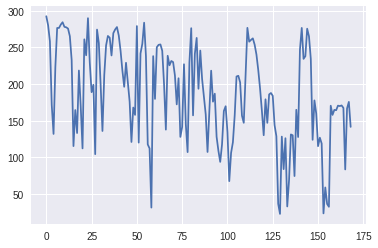

In [43]:
plt.plot(real_irrad_val)

In [0]:
dataset_total = pd.concat((dataset_train, dataset_test), axis=0)

In [46]:
dataset_total.head()

,Date,Avg_rad,SE,SA,TEMP,AP,RH,WS,WD,PWAT
0,1994-01-01,154.916667,-17.118333,-2.526667,11.808333,968.900000,44.304167,4.195833,301.375000,6.641667
1,1994-01-02,183.802083,-12.861250,-5.042500,7.437500,965.879167,66.295833,1.420833,209.666667,9.058333
2,1994-01-03,89.604167,-5.719583,-4.917500,9.283333,956.462500,70.662500,3.275000,123.625000,13.420833
3,1994-01-04,213.489583,3.547917,-2.772083,17.562500,961.125000,36.558333,4.900000,310.000000,13.445833
4,1994-01-05,296.333333,11.472500,-0.962917,14.608333,965.758333,50.462500,2.154167,87.666667,8.287500


In [0]:
inputs = dataset_total.iloc[len(dataset_total) - len(dataset_test) - timesteps:, 1:cols].values

In [49]:
inputs.shape

(229, 9)

In [0]:
inputs = sc.transform(inputs)

In [0]:
X_test = []
for i in range(timesteps, timesteps + len(dataset_test)):
    X_test.append(inputs[i - timesteps:i, 0:cols])
    
X_test = np.array(X_test)    

In [53]:
X_test.shape

(169, 60, 9)

Predict values.

In [0]:
predicted_irrad_val = regressor.predict(X_test)

In [61]:
predicted_irrad_val.shape

(169, 1)

In [0]:
temp = np.zeros((len(predicted_irrad_val), cols-1))
for i in range(0, len(predicted_irrad_val)):
    temp[i,0]=predicted_irrad_val[i, 0]

In [0]:
predicted_irrad_val = sc.inverse_transform(temp)[:,0]

In [64]:
temp

array([[0.74001133, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.76795346, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.81867492, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.37196875, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.3980279 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.44637981, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

**Visualize the reults.**

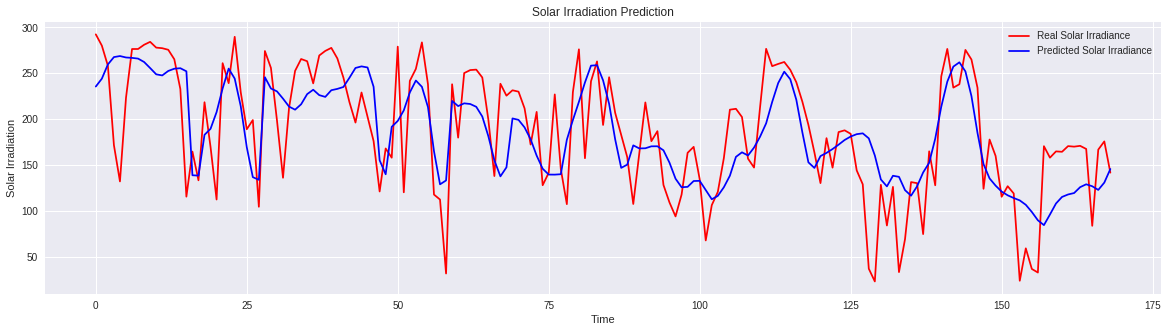

In [68]:
# Visualising the results
plt.figure(figsize=(20, 5))
plt.plot(real_irrad_val, color = 'red', label = 'Real Solar Irradiance')
plt.plot(predicted_irrad_val, color = 'blue', label = 'Predicted Solar Irradiance')
plt.title('Solar Irradiation Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Irradiation')
plt.legend()
plt.show()